In [2]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import anndata as ad
os.chdir(os.getcwd())

# Load raw data

In [33]:
#adata=sc.read_h5ad('../data/prelim_analysis.h5ad')
l=[]
for batch in os.listdir('../data/cellbender_output/'):
    input_file=os.path.join('../data',batch+'_cellbender_corrected.h5ad')
    adata_batch_raw=sc.read_h5ad(input_file)
    adata_batch_raw.obs_names_make_unique
    l.append(adata_batch_raw)

adata=ad.concat(l)  
adata=adata[adata.obs['cell_probability']>0.5,:]
adata.X=adata.layers['cellbender']
    

# Normalize data

In [34]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


# Plot RBC genes on UMAP

In [35]:
rcParams['figure.figsize']=(6,4.5)
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=15, metric='euclidean')
sc.tl.umap(adata_pp)

         Falling back to preprocessing with `sc.pp.pca` and default params.


[<AxesSubplot:title={'center':'HBB'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'HBA1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'HBA2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'HEMGN'}, xlabel='UMAP1', ylabel='UMAP2'>]

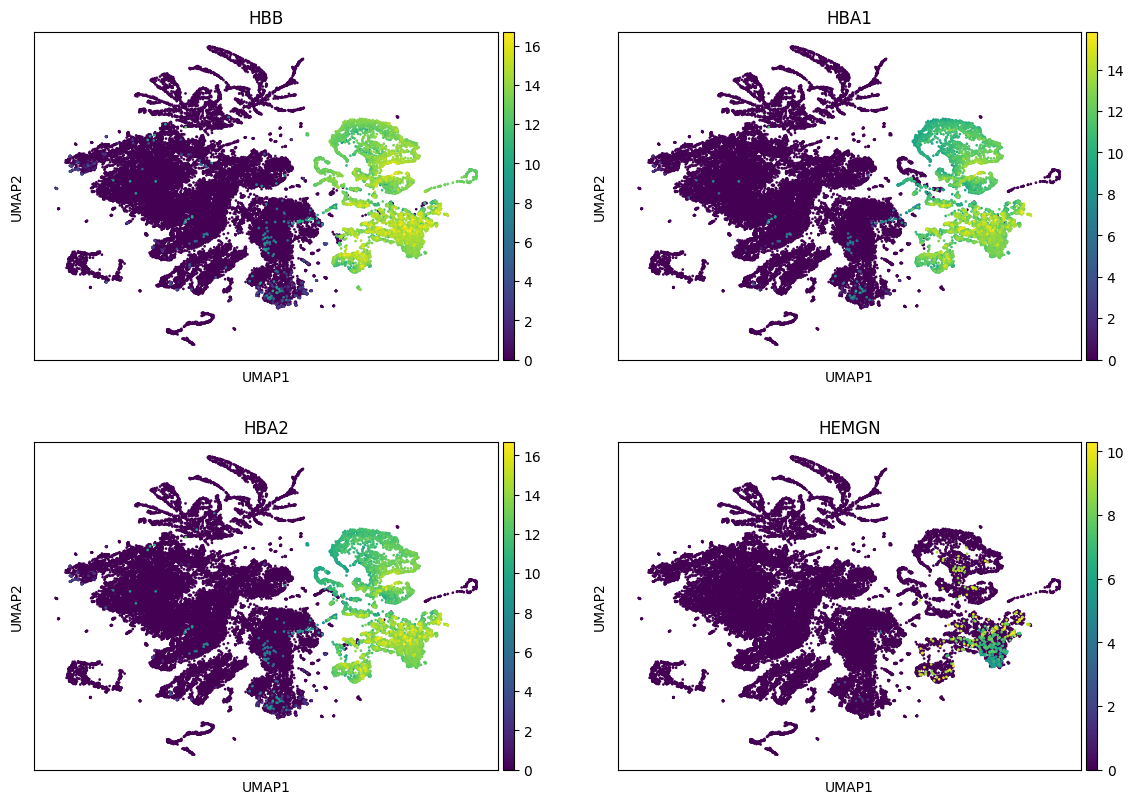

In [36]:
ery_genes=['HBB','HBA1','HBA2','HEMGN']
sc.pl.umap(adata_pp, color=ery_genes,show=False,size=15,ncols=2)

# Calculate RBC_score

In [37]:
sc.tl.score_genes(adata_pp, gene_list=ery_genes[0:2], score_name='RBC_score')

# Plot RBC_score
- Select a RBC_score threshold based on RBC_ascore distribution 
- plot UMAP with low/high RBC_score
- Calculate Leiden-clusters and check which cluster corresponds to high RBC score values

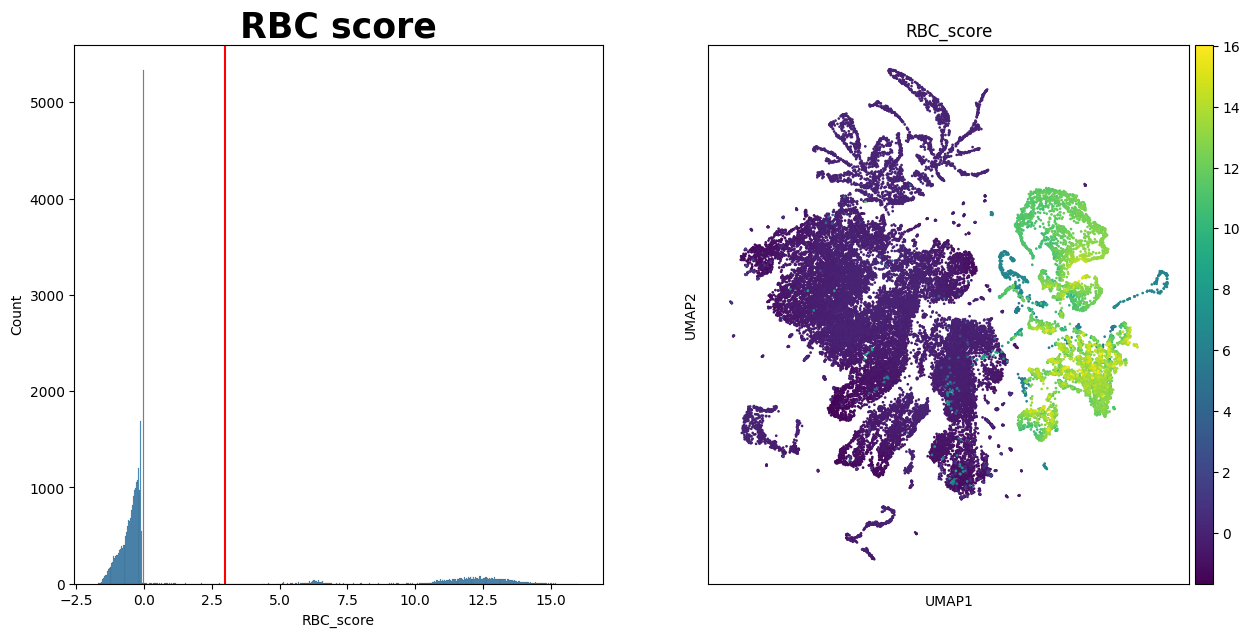

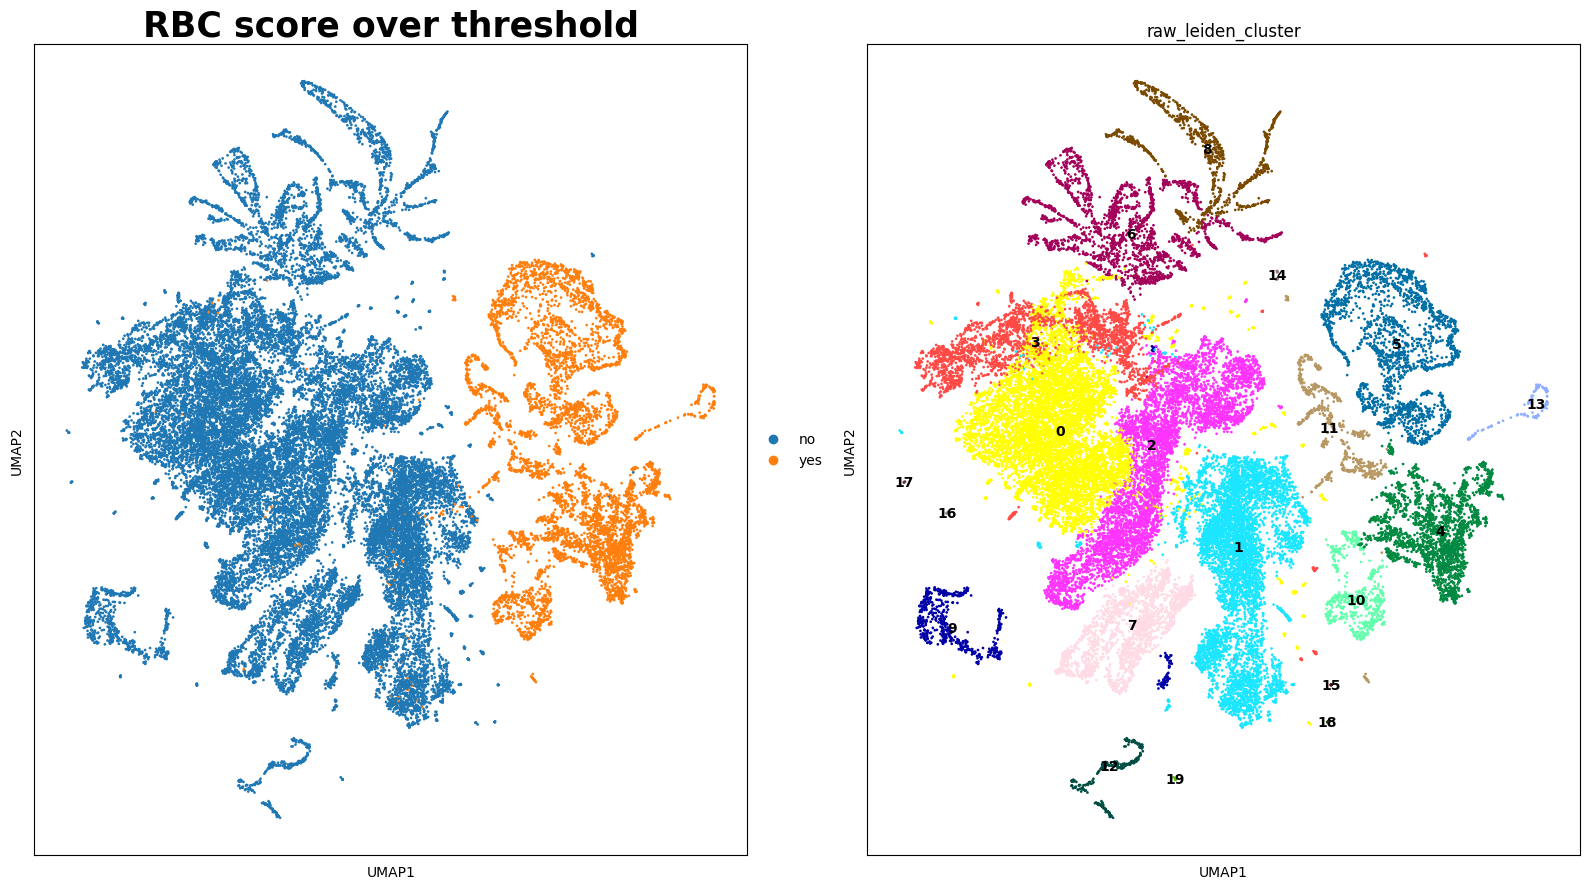

In [44]:
## Select rbc score threshold
rbc_thr=3
adata_pp.obs['RBC_score_high']='no'
adata_pp.obs.loc[adata_pp.obs['RBC_score']>rbc_thr,'RBC_score_high']='yes'

fig,ax=plt.subplots(1,2,figsize=(15,7))
sns.histplot(adata_pp.obs['RBC_score'],ax=ax[0])
ax[0].axvline(rbc_thr,color='red')
ax[0].set_title('RBC score',fontsize=25,fontweight='bold')

sc.pl.umap(adata_pp, color='RBC_score',show=False,size=15,ncols=2,ax=ax[1])

fig,ax=plt.subplots(1,2,figsize=(16,9))
sc.pl.umap(adata_pp, color='RBC_score_high',show=False,size=15,ncols=2,ax=ax[0])
ax[0].set_title('RBC score over threshold',fontsize=25,fontweight='bold')

#fig,ax=plt.subplots(1,1,figsize=(9,9))
sc.tl.leiden(adata_pp, key_added='raw_leiden_cluster', resolution=0.1)
sc.pl.umap(adata_pp, color='raw_leiden_cluster',show=False,size=15,ncols=2,ax=ax[1],legend_loc='on data')

plt.tight_layout()

## Drop the RBCs from the raw adata and save it

In [45]:
## Filter raw adata + save it
adata_filt=adata[adata_pp.obs['RBC_score_high']=='yes',:]
adata_filt.write_h5ad('../data/data_RBC_removed.h5ad')

/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/daniel.garger/anaconda3/envs/cellbender/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
